In [38]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [39]:
#Load dataset and parse to Dataframe
xlsx =pd.ExcelFile("dataset.xlsx")
Orders=xlsx.parse('Orders')
Product= xlsx.parse('Product')
Location= xlsx.parse('Location')
Customer= xlsx.parse('Customer')
Return= xlsx.parse('Return')
RFM_Score= xlsx.parse('RFM Score')

In [40]:
#Detecting missing or error values
Orders.isna().any()
Product.isna().any()
Location.isna().any()
Customer.isna().any()
Return.isna().any()
# Data doesn't have missing or error values

Returned    False
Order ID    False
dtype: bool

In [41]:
#group by returned product id and count
R_count = Return.groupby(["Order ID"])["Returned"].agg("count").reset_index()

In [42]:
# oders left join with R_count 
Orders_R= Orders.merge(R_count, how="left", on="Order ID")

In [43]:
# Because some orders_id have returned product.
# Then We can replace NaN values of Returned column of Orders_R = 0.
Orders_R.fillna(value=0, inplace=True)
Count_Frequency=Orders_R.groupby("Order ID").agg(Count_F=("Order ID","count")).reset_index()

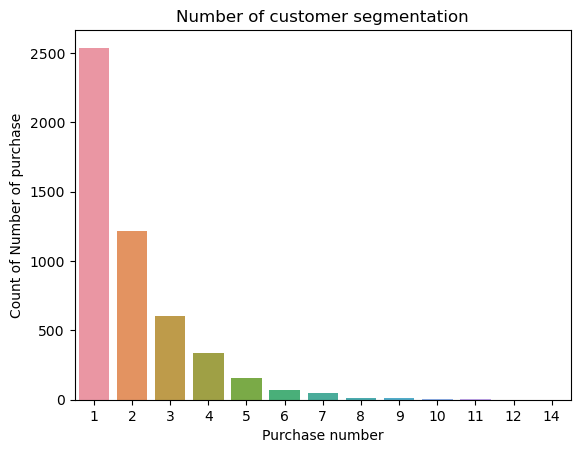

In [44]:
# Seaborn Countplot of Frequency
sns.countplot(x=Count_Frequency["Count_F"])
plt.title('Number of customer segmentation')
plt.xlabel('Purchase number')
plt.ylabel('Count of Number of purchase')
plt.show()

In [45]:
# Calculate the profit per unit
Orders_R["Profit_per_unit"]=Orders_R["Profit"]/Orders_R["Quantity"]

In [46]:
# Calculate the quantity after returned product
Orders_R["Quantity_R"]=Orders_R["Quantity"]- Orders_R["Returned"]

In [47]:
# Calculate the sales after returned product
Orders_R["Sales_R"]=Orders_R["Quantity_R"]*(Orders_R["Unit Price"]+Orders_R["Profit_per_unit"])

In [48]:
# Set date to calculate and add 1 day to d (to calculate the date distance more exactly)
d = datetime(year=2017, month=12, day=31) + timedelta(days=1)

In [49]:
#Calculate RFM 
df_customers= Orders_R.groupby(["Order ID"]).agg({"Order Date": lambda x: (d-x.max()).days,"Quantity_R":"count",
                                                 "Sales_R":"sum"}).reset_index()

In [50]:
# (RFM)Divide results by levels 1,2,3,4,5
df_customers["Recency_score"] = pd.cut(df_customers["Order Date"],5, labels =[5,4,3,2,1])
df_customers["Frequency_score"] = pd.cut(df_customers["Quantity_R"],5, labels =[1,2,3,4,5])
df_customers["Monetary_score"] = pd.cut(df_customers["Sales_R"],5, labels =[1,2,3,4,5])

In [51]:
# concate 3 score column to RFM_score
df_customers["RFM_score"] = df_customers.apply(lambda row: str(row["Recency_score"])+
                                              str(row["Frequency_score"])+
                                              str(row["Monetary_score"]), axis=1)

In [52]:
# Split the RFM_Score to more rows
RFM_Score['RFM_Score_List'] = RFM_Score['RFM Score'].str.split(', ')

# Use the explode method to create a new dataframe with one row for each RFM score in the list
RFM_Score_split = RFM_Score.explode('RFM_Score_List')

# Drop the original RFM Score column
RFM_Score_split.drop(columns=["RFM Score"], inplace=True)

# Rename RFM_Score_List as RFM Score
RFM_Score_split.rename(columns={"RFM_Score_List":"RFM_score"},inplace=True)

In [53]:
# df_customers left join with RFM_Score_split
customers_RFM = df_customers.merge(RFM_Score_split, how="left", on ="RFM_score")

In [54]:
#Group by Orders_R and take the Customer ID
Orders_group= Orders_R.groupby(["Order ID", "Customer ID"])["Quantity"].sum().reset_index()

In [55]:
# customers_RFM left join with Orders_group
Orders_RFM = customers_RFM.merge(Orders_group, how="left", on="Order ID").reset_index()

In [56]:
# Build a treemap of customer segmentation
treemap_data= Orders_RFM.groupby("Segment").agg(Segment_count=("Segment", "count")).reset_index()
fig = px.treemap(treemap_data, path=['Segment'], values='Segment_count', title='Treemap of customer segmentation')
fig.show()

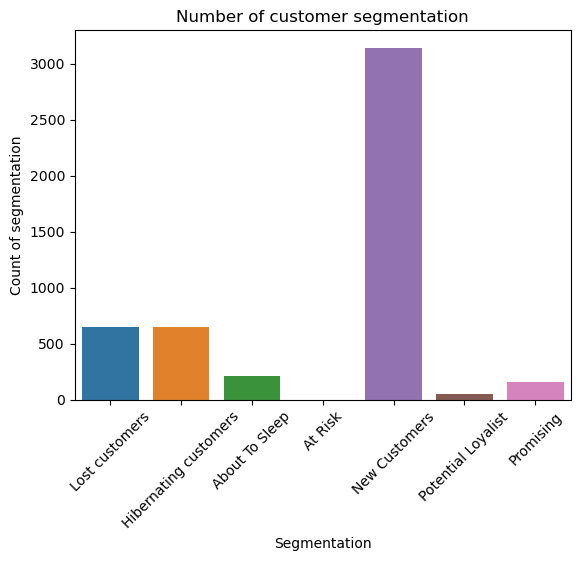

In [57]:
# Seaborn Countplot of customer segmentation
sns.countplot(x=Orders_RFM["Segment"])
plt.title('Number of customer segmentation')
plt.xlabel('Segmentation')
plt.ylabel('Count of segmentation')
plt.xticks(rotation=45)
plt.show()

In [58]:
# Orders_RFM left join with Orders_new
Orders_new = Orders.drop_duplicates(subset='Order ID')
Orders_RFM_m = Orders_RFM.merge(Orders_new, how="left", on=["Order ID","Customer ID"])
#Orders_RFM_m left join with Product_new
Product_new= Product.drop_duplicates(subset='Product ID')
Orders_Product =Orders_RFM_m.merge(Product_new, how="left", on="Product ID")

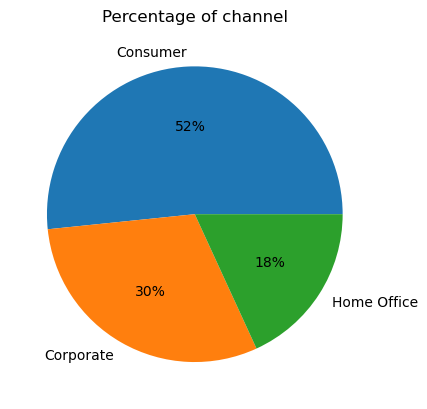

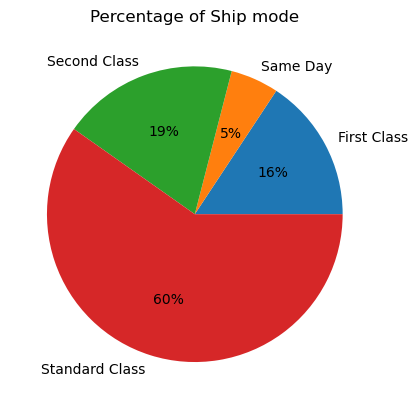

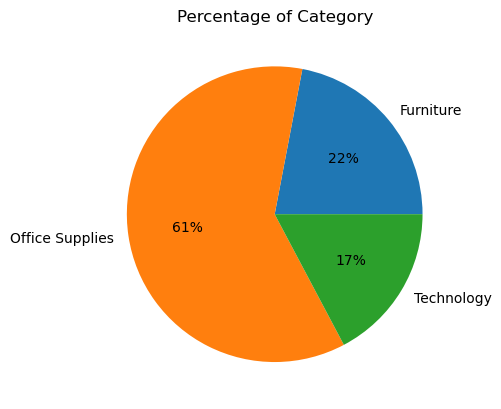

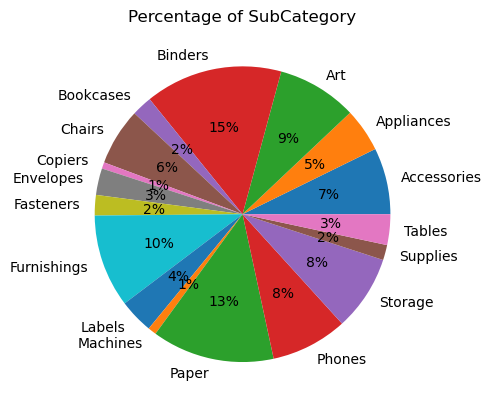

In [59]:
# Pie chart of Channel, Ship mode, Category, Sub-category
Orders_RFM_channel = Orders_RFM_m.groupby("Channel").agg(Channel_count=("Channel", "count")).reset_index()
plt.pie(Orders_RFM_channel["Channel_count"], labels=Orders_RFM_channel["Channel"], autopct='%1.0f%%')
plt.title('Percentage of channel')
plt.show()

#Pie chart of Ship mode
Orders_RFM_ship = Orders_RFM_m.groupby("Ship Mode").agg(Ship_count=("Ship Mode","count")).reset_index()
plt.pie(Orders_RFM_ship["Ship_count"], labels=Orders_RFM_ship["Ship Mode"], autopct='%.0f%%')
plt.title('Percentage of Ship mode')
plt.show()

#Pie chart of category
Orders_Product_category = Orders_Product.groupby("Category").agg(Category_count=("Category","count")).reset_index()
plt.pie(Orders_Product_category["Category_count"], labels=Orders_Product_category["Category"], autopct='%.0f%%')
plt.title('Percentage of Category')
plt.show()

#Pie chart of sub-category
Orders_Product_subcategory = Orders_Product.groupby("Sub-Category").agg(SubCategory_count=("Sub-Category","count")).reset_index()
plt.pie(Orders_Product_subcategory["SubCategory_count"], labels=Orders_Product_subcategory["Sub-Category"], autopct='%.0f%%')
plt.title('Percentage of SubCategory')
plt.show()

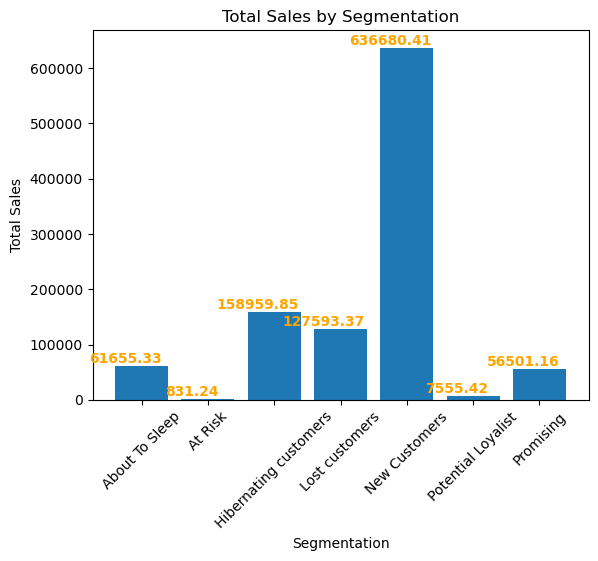

In [60]:
#Bar plot: Total Sales by Segmentation
Sales_seg=Orders_RFM_m.groupby("Segment").agg(sum_sales=("Sales", "sum")).reset_index()
plt.bar(Sales_seg["Segment"],Sales_seg["sum_sales"])
for i, v in enumerate(round(Sales_seg["sum_sales"],2)):
    plt.text(i-.25, v+0.5, str(v), color='orange', fontweight='bold', ha='center', va='bottom')
plt.title('Total Sales by Segmentation')
plt.xlabel('Segmentation')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

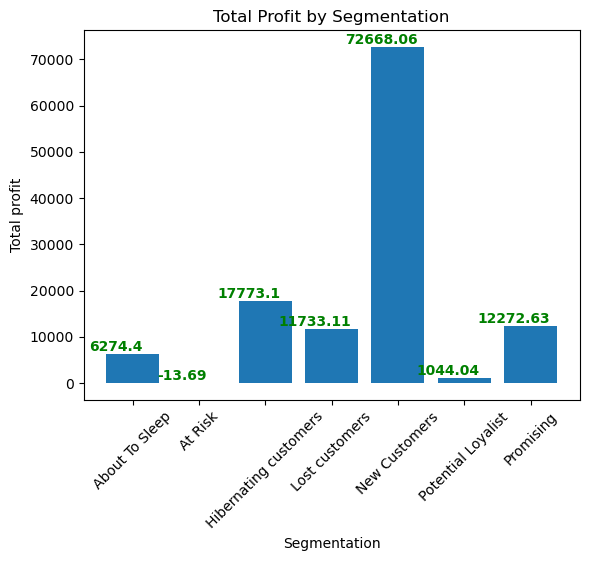

In [61]:
#Bar plot: Total Profit by Segmentation
Profit_seg=Orders_RFM_m.groupby("Segment").agg(sum_profit=("Profit", "sum")).reset_index()
plt.bar(Profit_seg["Segment"],Profit_seg["sum_profit"])
for i, v in enumerate(round(Profit_seg["sum_profit"],2)):
    plt.text(i-.25, v+0.5, str(v), color='green', fontweight='bold', ha='center', va='bottom')
plt.title('Total Profit by Segmentation')
plt.xlabel('Segmentation')
plt.ylabel('Total profit')
plt.xticks(rotation=45)
plt.show()

In [62]:
# Orders_Product left join with Location
Location_new= Location.drop_duplicates(subset=['Postal Code'])
P_l = Product_new.merge(Location_new, how="left", on ="Row ID")
Orders_Product_Location =Orders_Product.merge(P_l, how="left", on="Product ID").reset_index()

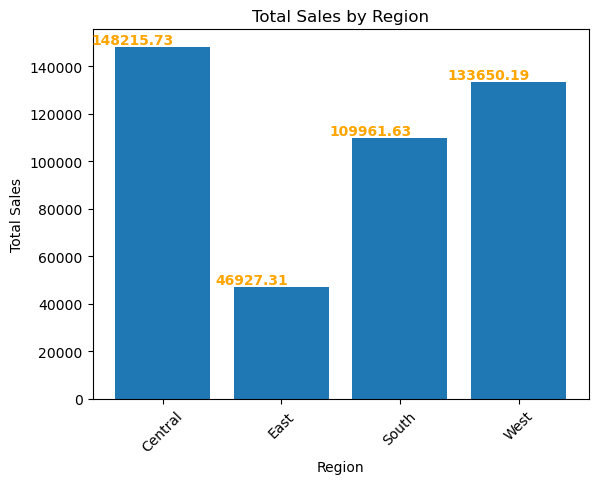

In [63]:
#Bar plot: Total Sales by Region
Sales_Region=Orders_Product_Location.groupby("Region").agg(sum_sales=("Sales", "sum")).reset_index()
plt.bar(Sales_Region["Region"],Sales_Region["sum_sales"])
for i, v in enumerate(round(Sales_Region["sum_sales"],2)):
    plt.text(i-.25, v+0.5, str(v), color='orange', fontweight='bold', ha='center', va='bottom')
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

In [64]:
# Build a treemap of state
treemap_state= Orders_Product_Location.groupby("State").agg(State_count=("State", "count")).reset_index()
fig = px.treemap(treemap_state, path=['State'], values='State_count', title='Order by of state')
fig.show()